In [1]:
''' Polygon '''

' Polygon '

In [2]:
import fiona
import geopandas
import shapely.speedups
from shapely import geometry
from shapely.geometry import shape, mapping

/var/folders/rt/k30tjkvx04vdq1qxvtwsb47m0000gn/T/ipykernel_61408/3123370074.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [3]:
import matplotlib.pyplot as plt

In [4]:
%ls

example_buffers.gpkg*            shapely.object.difference.ipynb


In [5]:
input_filename = "example_buffers.gpkg"

output_filename = "example_buffers_difference.gpkg"

In [6]:
with fiona.open(input_filename, mode='r') as input_geopackage:
    input_layers = fiona.listlayers(input_filename)

In [7]:
input_layers

['exampleESRI102032', 'exampleESRI102032_buffer1']

In [8]:
input_layer1 = input_layers[0]

In [9]:
with fiona.open(input_filename, mode='r', layer=input_layer1) as layer1:
	layer1_polygons = [shape(element['geometry']) for element in list(layer1)]	# Collection (fiona.collection.Collection) to list of polygons
	layer1_geoseries = geopandas.GeoSeries(layer1_polygons)

<AxesSubplot: >

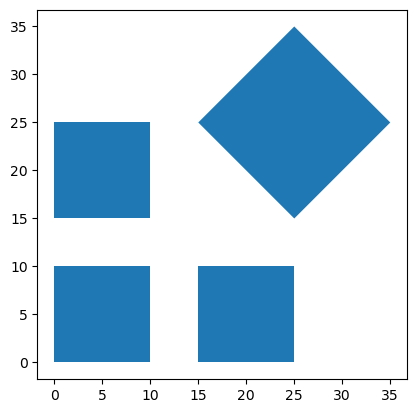

In [10]:
layer1_geoseries.plot()

In [11]:
input_layer2 = input_layers[1]

In [12]:
with fiona.open(input_filename, mode='r', layer=input_layer2) as layer2:
	layer2_polygons = [shape(element['geometry']) for element in list(layer2)]	# Collection (fiona.collection.Collection) to list of polygons
	layer2_geoseries = geopandas.GeoSeries(layer2_polygons)		# list of polygons to GeoSeries

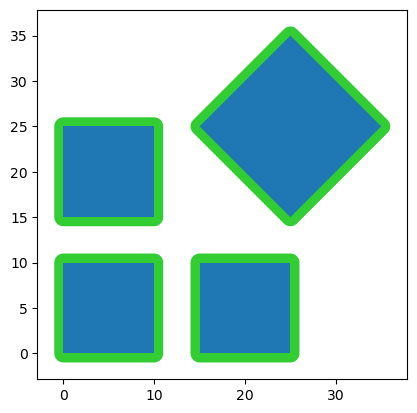

In [14]:
fig, ax = plt.subplots()
layer2_geoseries.plot(ax=ax, color='limegreen')
layer1_geoseries.plot(ax=ax, color='tab:blue')
plt.show()

In [15]:
layer1_geoseries.sindex		# create spatial index

layer2_geoseries.sindex		# create spatial index

In [16]:
layer1_geodataframe = geopandas.GeoDataFrame(geometry=layer1_geoseries)

layer2_geodataframe = geopandas.GeoDataFrame(geometry=layer2_geoseries)

In [17]:
layer1_geoseries.index = geopandas.sjoin(layer1_geodataframe, layer2_geodataframe, how='left', predicate='within').index_right

# layer2_geoseries.index = geopandas.sjoin(layer2_geodataframe, layer0_geodataframe, how='left', predicate='Contains').index_right

In [18]:
difference_polygons = [polygon2.difference(layer1_geoseries[i]) for i, polygon2 in enumerate(layer2_polygons)]

<AxesSubplot: >

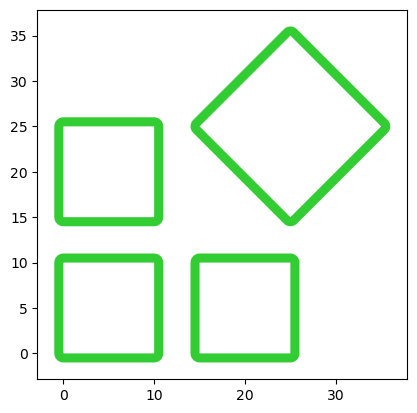

In [20]:
geopandas.GeoDataFrame(geometry=difference_polygons).plot(color='limegreen')

In [21]:
# Cast to MultiPolygon

from shapely.geometry.multipolygon import MultiPolygon

def cast_to_multipolygon(geom):
	if type(geom) == geometry.polygon.Polygon:
		return geometry.multipolygon.MultiPolygon([geom])
    
difference_multipolygons = list(map(cast_to_multipolygon, difference_polygons))

In [22]:
output_layer = input_layer2

schema = {
	"geometry": "MultiPolygon", "properties": {"id": "int"}
}

with fiona.open(output_filename, mode='w', driver='GPKG', schema=schema, crs='ESRI:102032', layer=output_layer) as output_geopackage:
	for id, geoms in enumerate(difference_multipolygons):
		output_geopackage.write({"geometry": mapping(geoms), "properties": {"id": id}})